In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://cdn.downtoearth.org.in/library/large/2020-03-01/0.01792700_1583044755_coronavirus-illustration-carousel.jpg")

# COVID-19 Global Outlook: Modelling

Coronavirus disease 2019 (COVID-19) is an infectious disease caused by severe acute respiratory syndrome. The first disease was identified in Dicember 2019 in Wuhan. 
On March 11 2020, after 118,000 people being infected in 114 Countries, and causing the death of 4,291 people, COVID-19 has been recognized as a pandemic.
Today, April 13,2020, the pandemic infected 1,854,464 people in 185 countries, causing the death of 114,331 people.

In the context of the global COVID-19 pandemic, we follow the suggestions from Kaggle's competitions in order to provide useful insights about the virus' spread. Starting from a global exploratory analysis, then we focus on virus' modelling and prediction for the countries with the largest number of confirmed cases. For modelling, we implement SIR Model with some extensions and, for prediction, logistic and Gompertz model. At the end, we choose the best model based on $R^{2}$ score, check the predictions' numbers about confirmed and fatalities for the next time interval and display some results from NLTK Sentiment analysis. 

Data: [COVID19 Global Forecasting](https://www.kaggle.com/c/covid19-global-forecasting-week-4)

**TABLE OF CONTENTS**

2. [Modelling](#section2)

    2.1. [SIR model](#section21)
    
    2.2. [SIR-Model with Lockdown](#section22)
    
      2.2.1. [Fitting SIR with Lockdown to data](#section131)
      
    2.3. [SIR with time-dependent R_0 and CFR](#section21)
    
      2.3.1. [Fitting extended SIR to data](#section131)

# **2. Modelling** <a id="section2"></a>

Firstly, we define the model function for fit and plotting. After, we fit the model only to some selected countries because it's difficult to initialize the fit parameters correctly for countries with few confirmed cases and fatalities or states with zero or much less statistics, since the results for some of them can be ambiguous.

## **2.1. SIR Model** <a id="section21"></a>

SIR model is a kind of compartmental model describing the dynamics of infectious disease. You may wonder why it is called the “compartmental model.” The model divides the population into compartments. Each compartment is expected to have the same characteristics. SIR represents the three compartments segmented by the model.

* **Susceptible (S)**. Susceptible is a group of people who are vulnerable to exposure with infectious people. They can be patient when the infection happens.
* **Infectious (I)**. The group of infectious represents the infected people. They can pass the disease to susceptible people and can be recovered in a specific period. 
* **Recovered (R)**. Recovered people get immunity so that they are not susceptible to the same illness anymore.

SIR model is a framework describing how the number of people in each group can change over time.

<img src="https://www.lewuathe.com/assets/img/posts/2020-03-11-covid-19-dynamics-with-sir-model/sir.png" width="500px">
Image by Kai Sasaki from [lewuathe.com](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html)

SIR model allows us to describe the number of people in each compartment with the ordinary differential equation. 
* $\beta$ (**Contagion Rate**) is a parameter controlling how much the disease can be transmitted through exposure. It is determined by the chance of contact and the probability of disease transmission.
* $\gamma$ (**Recovery Rate**) is a parameter expressing how much the disease can be recovered in a specific period. Once the people are healed, they get immunity. There is no chance for them to go back susceptible again.

$$ {dS \over dt} = - {\beta S I \over N} $$

$$ {dI \over dt} = {\beta S I \over N} - \gamma I$$

$$ {dR \over dt} = \gamma I$$

We do not consider the effect of the natural death or birth rate because the model assumes the outstanding period of the disease is much shorter than the lifetime of the human. It lets us know the importance of knowing two parameters, $\beta$ and $\gamma$. When we can estimate the two values, there are several insights derived from it. If the $D$ is the average days to recover from infectious, it is derived from $\gamma$. 

$$ {D} = - {1 \over \gamma } $$

Also, we can estimate the nature of the disease in terms of the power of infection.

$$ {R_{0}} = - {\beta \over \gamma } $$

It is called a basic reproduction number. $R_{0}$ is the average number of people infected from one other person. If it is high, the probability of pandemic is also higher. 


In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [3]:
api.competition_download_file('covid19-global-forecasting-week-4','train.csv')
api.competition_download_file('covid19-global-forecasting-week-4','test.csv')
api.competition_download_file('covid19-global-forecasting-week-4','submission.csv')

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import mpld3
mpld3.enable_notebook()

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission_example = pd.read_csv("submission.csv")

train["Country_Region"] = [country_name.replace("'","") for country_name in train["Country_Region"]]
train = train.groupby(['Country_Region', 'Date'], as_index=False)
train = train.aggregate(np.sum)

In [6]:
from scipy.integrate import odeint

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

We now want to add *cumulative* Deaths $X$ to the model: $X(t) = \textit{number of deaths from day 0 to day t}$ for $t\geq 14$, else $0$. 

Recursively, the number of cumulative deaths on day $t$ is equal to the number of cumulative deaths on day $t-1$ (that's $=X(t-1)$) plus the number of newly infected 13 days prior multiplied with the case fatality rate $\alpha$ (alpha) (13 days as the average time from infection until death [here](https://wwwnc.cdc.gov/eid/article/26/6/20-0320_article)).

Now, the number of newly infected 13 days prior (that's the people who can die on day $t$) is equal to the number of infected 14 days prior multiplied with the expected amount of people an infected person infects per day (that's $\beta$). So the number of newly infected 13 days prior is $\beta \cdot I(t-14)$.

Putting it all together: $X(t) = X(t-1) + \alpha \cdot \beta \cdot I(t-14)$.

This is equal to the closed form formula $X(t) = \alpha \cdot \beta \cdot \displaystyle \sum_{i=0}^{t-14} I(i)$


In [7]:
def SIR_model(N, D, R_0, CaseFatalityRate, max_days):
    '''
    N: total population
    D, R_0, CaseFatalityRate: see texts above
    '''
    I0, R0 = 1, 0  # Initial number of infected and recovered individuals (1 infected, 0 recovered) [this R0 has nothing to do with the basic reproduction number R0]
    S0 = N - I0 - R0 # Initial number of susceptible (everyone else)

    gamma = 1.0 / D  # see texts above
    beta = R_0 * gamma  # see texts above
    alpha = CaseFatalityRate

    t = np.linspace(0, max_days, max_days) # Grid of time points (in days)

    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    # Adding deaths (see text above)
    X = np.zeros(max_days)
    for day in range(13, max_days):
        X[day] = sum(I[:day-13])
    X = alpha * beta * X


    # Plot the data on three separate curves for S(t), I(t) and R(t)
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, X, 'r', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

    ax.set_xlabel('Time (days)')
    ax.title.set_text('SIR-Model. Total Population: ' + str(N) + ", Days Infectious: " + str(D) + ", R_0: " + str(R_0) + ", CFR: " + str(CaseFatalityRate*100) + "%")
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

## **2.2. SIR-Model with Lockdown** <a id="section22"></a>

In [8]:
Image(url= 'https://miro.medium.com/max/1400/1*jOyyJwEmor8XSbngQEJRVg.jpeg')

The starting point of the analysis is to find parameters for Days infectious, $R_{0}$ and CFR for the SIR model. 
Since the number of confirmed cases is far from the real number (not the whole population is getting tested), we used the number of deaths from the dataset in order to find the parameters. 

Many countries implement National intervention policies, like lockdowns in order to reduce the contagion. The *lockdown* greatly reduces the basic reproduction number $R_{0}$, transforming this parameter into $R_{0,2}$ that comes into effect on day L (i.e., lockdown). 

In [9]:
def SIR_model_with_lockdown(N, D, R_0, CaseFatalityRate, max_days, L, R_0_2):
    '''
    N: total population
    D, R_0, CaseFatalityRate, ...: see texts above
    '''
    # BEFORE LOCKDOWN (same code as first model)
    I0, R0 = 1, 0  # Initial number of infected and recovered individuals (1 infected, 0 recovered) [this R0 has nothing to do with the basic reproduction number R0]
    S0 = N - I0 - R0 # Initial number of susceptible (everyone else)

    gamma = 1.0 / D  # see texts above
    beta = R_0 * gamma  # see texts above
    alpha = CaseFatalityRate

    t = np.linspace(0, L, L)  # Grid of time points (in days)
    
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    
    
    # AFTER LOCKDOWN
    I0_2, R0_2, S0_2 = I[-1], R[-1], S[-1]  # beginning of lockdown -> starting Infected/Susceptible/Recovered numbers are the numbers at the end of no-lockdown period

    gamma = 1.0 / D  # same after lockdown
    beta_2 = R_0_2 * gamma
    alpha = CaseFatalityRate  # same after lockdown

    t_2 = np.linspace(0, max_days - L + 1, max_days - L + 1)
    
    # Initial conditions vector
    y0_2 = S0_2, I0_2, R0_2
    # Integrate the SIR equations over the time grid, t.
    ret_2 = odeint(deriv, y0_2, t_2, args=(N, beta_2, gamma))
    S_2, I_2, R_2 = ret_2.T

    
    # COMBINING PERIODS
    S_full = np.concatenate((S, S_2[1:]))
    I_full = np.concatenate((I, I_2[1:]))
    R_full = np.concatenate((R, R_2[1:]))
    t_full = np.linspace(0, max_days, max_days)
    
    # Adding deaths
    X = np.zeros(max_days)
    for day in range(13, max_days):
        for valid_day in range(day-13):
            if valid_day < L:
                X[day] += alpha * beta * I_full[valid_day]
            else:
                X[day] += alpha * beta_2 * I_full[valid_day]

    

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t_full, S_full, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t_full, I_full, 'y', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t_full, X, 'r', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t_full, R_full, 'g', alpha=0.7, linewidth=2, label='Recovered')

    ax.set_xlabel('Time (days)')
    ax.title.set_text('SIR-Model with Lockdown. Total Population: ' + str(N) + 
                      ", Days Infectious: " + str(D) + ", R_0: " + str(R_0) + 
                      ", CFR: " + str(CaseFatalityRate*100) + " R_0_2: " + str(R_0_2) + 
                      ", L: " + str(L) + " days")
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    plt.text(L,N/20,'Lockdown')
    plt.plot(L, 0, marker='o', markersize=6, color="red")
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

## **2.3 Fitting SIR with Lockdown to data** <a id="section23"></a>

Firstly, we define the variables' model and after we fit the SIR-Model's Dead Curve to real data:
* **max_days** is set to len(train.groupby("Date").sum().index) for comparisons
* **N** is fixed for each country, i.e. the total population
* **L** is fixed for each country, i.e. lockdown date
* **D** is set to vary from 5 to 20 (since it takes on avg. 5 days to show symptoms, at most 14, according to studies)
* **CFR** is set to vary from  0.1%−10% 
* **$R_{0}$** and **$R_{0,2}$** are set to vary from 0.1 to 3.5

In [10]:
def SIR_model_with_lockdown_deaths(x, N, D, R_0, CaseFatalityRate, max_days, L, R_0_2):
    # BEFORE LOCKDOWN (same code as first model)
    I0, R0 = 1, 0  # Initial number of infected and recovered individuals (1 infected, 0 recovered) [this R0 has nothing to do with the basic reproduction number R0]
    S0 = N - I0 - R0 # Initial number of susceptible (everyone else)

    gamma = 1.0 / D  # see texts above
    beta = R_0 * gamma  # see texts above
    alpha = CaseFatalityRate

    t = np.linspace(0, L, L)  # Grid of time points (in days)
    
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    
    
    # AFTER LOCKDOWN
    I0_2, R0_2, S0_2 = I[-1], R[-1], S[-1]  # beginning of lockdown -> starting Infected/Susceptible/Recovered numbers are the numbers at the end of no-lockdown period

    gamma = 1.0 / D  # same after lockdown
    beta_2 = R_0_2 * gamma
    alpha = CaseFatalityRate  # same after lockdown

    t_2 = np.linspace(0, max_days - L + 1, max_days - L + 1)
    
    # Initial conditions vector
    y0_2 = S0_2, I0_2, R0_2
    # Integrate the SIR equations over the time grid, t.
    ret_2 = odeint(deriv, y0_2, t_2, args=(N, beta_2, gamma))
    S_2, I_2, R_2 = ret_2.T

    
    # COMBINING PERIODS
    S_full = np.concatenate((S, S_2[1:]))
    I_full = np.concatenate((I, I_2[1:]))
    R_full = np.concatenate((R, R_2[1:]))
    t_full = np.linspace(0, max_days, max_days)
    
    # Adding deaths
    X = np.zeros(max_days)
    for day in range(13, max_days):
        for valid_day in range(day-13):
            if valid_day < L:
                X[day] += alpha * beta * I_full[valid_day]
            else:
                X[day] += alpha * beta_2 * I_full[valid_day]
    return X[x]

The code above defines a function with signature SIR_model_with_lockdown_deaths(x, N, D, R_0, CaseFatalityRate, max_days, L, R_0_2) that takes as input the same variables as before and an x and returns the number of fatalities on day x. This function will be used to find suited parameters D, CFR, R_0 and R_0_2 for the model.

In [11]:
!pip install lmfit

In [12]:
api.dataset_download_file('tanuprabhu/population-by-country-2020','population_by_country_2020.csv')

True

In [13]:
from lmfit import Model

# Load countries data file (from https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions)
world_population = pd.read_csv("population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

world_population.head(20)

,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1438116346,153,9388211,38,61
1,India,1377011281,464,2973190,28,35
2,US,330578810,36,9147420,38,83
3,Indonesia,272884327,151,1811570,30,56
4,Pakistan,219922471,287,770880,23,35
5,Brazil,212228418,25,8358140,33,88
6,Nigeria,204968096,226,910770,18,52
7,Bangladesh,164327299,1265,130170,28,39
8,Russia,145920988,9,16376870,40,74
9,Mexico,128633396,66,1943950,29,84


We now define 
1. **`fit_SIR`**: this function takes a country name, lockdown data (and opt. region name) and first gathers the data (fatalities progression, population, etc.) and then fits the `SIR_model_with_lockdown_deaths`-function from above with fixed N (population), max_days (however many dates are supplied), L (lockdown date) and varying D, R_0, R_0_2, CFR. The function returns the lmfit-module's result object and the country name. The result object contains all we want to know about the curve fitting.
2. **`fitted_plot`**: this function takes a lmfit-result-object and country name and plots the fitted SIR-model against the real curve.

In [14]:
lockdown_dates = {"Italy": "2020-03-10", "Spain": "2020-03-15", "US": "2020-03-20", "Germany": "2020-03-23", "France": "2020-03-17", "United Kingdom":"2020-03-23", "China":"2020-01-23", "Iran":"2020-03-25"}

def fit_SIR(country_name, lockdown_date=None):
    """
    y_data: the fatalities data of one country/region (array)
    population: total population of country
    lockdown_date: format YYYY-MM-DD
    """
    if lockdown_date is None:
        lockdown_date = lockdown_dates[country_name]
        
    y_data = train[(train["Country_Region"] == country_name)].Fatalities.values
    max_days = len(train.groupby("Date").sum().index) # constant for all countries

    # country specific values
    N = world_population.loc[world_population['Country (or dependency)'] == country_name]["Population (2020)"].values[0]
    L = train.groupby("Date").sum().index.tolist().index(lockdown_date)  # index of the lockdown date

    # x_data is just [0, 1, ..., max_days] array
    x_data = np.linspace(0, max_days - 1, max_days, dtype=int)
    
    # curve fitting from here
    mod = Model(SIR_model_with_lockdown_deaths)

    # initial values and bounds
    mod.set_param_hint('N', value=N)
    mod.set_param_hint('max_days', value=max_days)
    mod.set_param_hint('L', value=L)
    mod.set_param_hint('D', value=10, min=4, max=25)
    mod.set_param_hint('CaseFatalityRate', value=0.01, min=0.0001, max=0.1)
    mod.set_param_hint('R_0', value=2.0, min=0.1, max=5.0)
    mod.set_param_hint('R_0_2', value=2.0, min=0.1, max=5.0)

    params = mod.make_params()

    # fixing constant parameters
    params['N'].vary = False
    params['max_days'].vary = False
    params['L'].vary = False

    result = mod.fit(y_data, params, x=x_data, method="least_squares")
    
    return result, country_name

def fitted_plot(result, country_name, region_name=None):
    y_data = train[(train["Country_Region"] == country_name)].Fatalities.values
    max_days = len(train.groupby("Date").sum().index) # constant for all countries
    x_data = np.linspace(0, max_days - 1, max_days, dtype=int)
    x_ticks = train[train["Country_Region"] == "Germany"].Date.values  # same for all countries
    
    plt.figure(figsize=(10,5))
    
    real_data, = plt.plot(x_data, y_data, 'bo', label="real data")
    SIR_fit = plt.plot(x_data, result.best_fit, 'r-', label="SIR model")
    
    plt.xlabel("Day")
    plt.xticks(x_data[::10], x_ticks[::10])
    plt.ylabel("Fatalities")
    plt.title("Real Data vs SIR-Model in " + country_name)
    plt.legend(numpoints=1, loc=2, frameon=None)
    plt.show()

[[Model]]
    Model(SIR_model_with_lockdown_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 30
    # data points      = 82
    # variables        = 4
    chi-square         = 5990099.25
    reduced chi-square = 76796.1442
    Akaike info crit   = 926.309742
    Bayesian info crit = 935.936619
[[Variables]]
    N:                 6.048088e+07 (fixed)
    D:                 4.00000000 +/- 0.85950249 (21.49%) (init = 10)
    R_0:               1.85468876 +/- 0.20788455 (11.21%) (init = 2)
    CaseFatalityRate:  0.10000000 +/- 0.03753880 (37.54%) (init = 0.01)
    max_days:          82 (fixed)
    L:                 48 (fixed)
    R_0_2:             0.98912203 +/- 0.01758624 (1.78%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, R_0)                =  0.989
    C(D, R_0_2)              =  0.904
    C(R_0, R_0_2)            =  0.857
    C(R_0, CaseFatalityRate) = -0.449
    C(D, CaseFatalityRate)   = -0.311


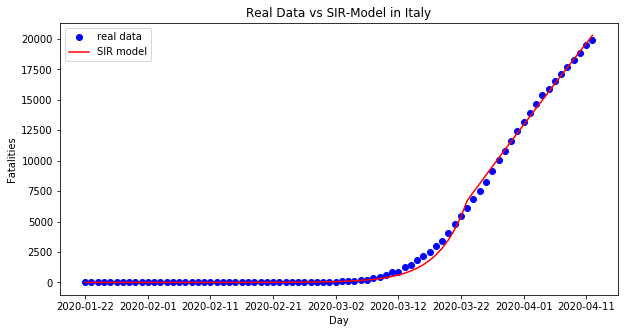

In [15]:
result, _ = fit_SIR("Italy")
print(result.fit_report())
fitted_plot(result, "Italy")

[[Model]]
    Model(SIR_model_with_lockdown_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 66
    # data points      = 82
    # variables        = 4
    chi-square         = 1576719.31
    reduced chi-square = 20214.3501
    Akaike info crit   = 816.859284
    Bayesian info crit = 826.486161
[[Variables]]
    N:                 4.675088e+07 (fixed)
    D:                 4.00000000 +/- 0.62894059 (15.72%) (init = 10)
    R_0:               1.88714330 +/- 0.15261852 (8.09%) (init = 2)
    CaseFatalityRate:  0.02223046 +/- 0.00531550 (23.91%) (init = 0.01)
    max_days:          82 (fixed)
    L:                 53 (fixed)
    R_0_2:             1.02319472 +/- 0.02081786 (2.03%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, R_0)                  =  0.993
    C(D, R_0_2)                =  0.966
    C(R_0, R_0_2)              =  0.948
    C(R_0, CaseFatalityRate)   = -0.365
    C(D, CaseFatalityRate)     = -0.251
    

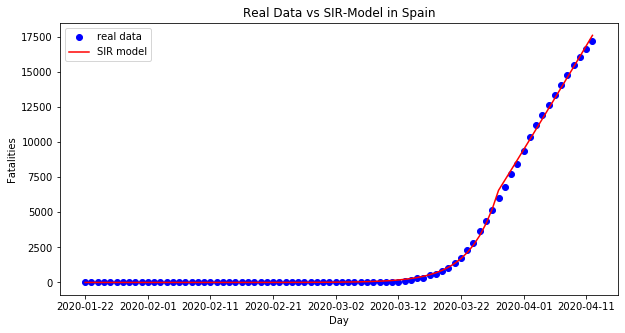

In [16]:
result, _ = fit_SIR("Spain")
print(result.fit_report())
fitted_plot(result, "Spain")

[[Model]]
    Model(SIR_model_with_lockdown_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 51
    # data points      = 82
    # variables        = 4
    chi-square         = 134072.284
    reduced chi-square = 1718.87544
    Akaike info crit   = 614.752040
    Bayesian info crit = 624.378917
[[Variables]]
    N:                 8.372584e+07 (fixed)
    D:                 4.00000000 +/- 2.87555704 (71.89%) (init = 10)
    R_0:               1.69195737 +/- 0.50512241 (29.85%) (init = 2)
    CaseFatalityRate:  0.01722210 +/- 0.00681689 (39.58%) (init = 0.01)
    max_days:          82 (fixed)
    L:                 61 (fixed)
    R_0_2:             1.07298759 +/- 0.16758166 (15.62%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, R_0)                  =  1.000
    C(D, R_0_2)                =  0.991
    C(R_0, R_0_2)              =  0.988
    C(CaseFatalityRate, R_0_2) =  0.861
    C(D, CaseFatalityRate)     =  0.825
  

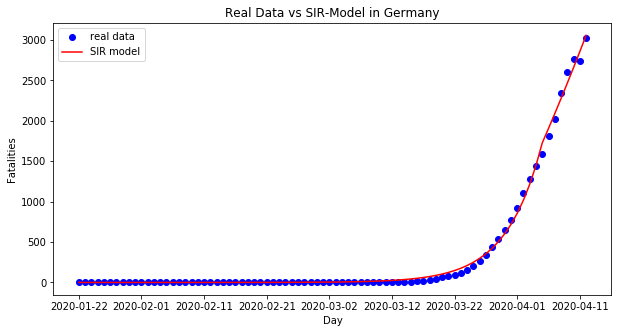

In [17]:
result, _ = fit_SIR("Germany")
print(result.fit_report())
fitted_plot(result, "Germany")

[[Model]]
    Model(SIR_model_with_lockdown_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 192
    # data points      = 82
    # variables        = 4
    chi-square         = 2494363.34
    reduced chi-square = 31979.0172
    Akaike info crit   = 854.471636
    Bayesian info crit = 864.098513
[[Variables]]
    N:                 6.524227e+07 (fixed)
    D:                 4.00000000 +/- 4.47175749 (111.79%) (init = 10)
    R_0:               2.15373189 +/- 1.41167677 (65.55%) (init = 2)
    CaseFatalityRate:  2.4182e-04 +/- 2.4781e-04 (102.47%) (init = 0.01)
    max_days:          82 (fixed)
    L:                 55 (fixed)
    R_0_2:             1.81463698 +/- 1.09139326 (60.14%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, R_0)                  =  1.000
    C(CaseFatalityRate, R_0_2) = -0.999
    C(R_0, R_0_2)              =  0.998
    C(D, R_0_2)                =  0.998
    C(R_0, CaseFatalityRate)   = -0.994

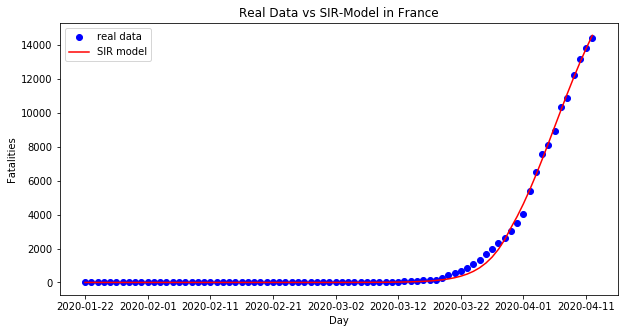

In [18]:
result, _ = fit_SIR("France")
print(result.fit_report())
fitted_plot(result, "France")

[[Model]]
    Model(SIR_model_with_lockdown_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 127
    # data points      = 82
    # variables        = 4
    chi-square         = 1369965.74
    reduced chi-square = 17563.6634
    Akaike info crit   = 805.333318
    Bayesian info crit = 814.960195
[[Variables]]
    N:                 3.305788e+08 (fixed)
    D:                 4.00000000 +/- 1.06092836 (26.52%) (init = 10)
    R_0:               1.98112777 +/- 0.27630514 (13.95%) (init = 2)
    CaseFatalityRate:  0.00187252 +/- 5.4263e-04 (28.98%) (init = 0.01)
    max_days:          82 (fixed)
    L:                 58 (fixed)
    R_0_2:             1.37703471 +/- 0.11533611 (8.38%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, R_0_2)                =  0.999
    C(D, R_0)                  =  0.997
    C(R_0, R_0_2)              =  0.997
    C(R_0, CaseFatalityRate)   = -0.319
    C(CaseFatalityRate, R_0_2) = -0.262
  

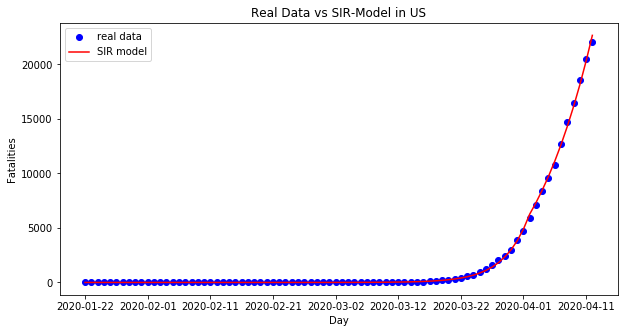

In [19]:
result, _ = fit_SIR("US")
print(result.fit_report())
fitted_plot(result, "US")

[[Model]]
    Model(SIR_model_with_lockdown_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 61
    # data points      = 82
    # variables        = 4
    chi-square         = 394018.099
    reduced chi-square = 5051.51409
    Akaike info crit   = 703.149496
    Bayesian info crit = 712.776373
[[Variables]]
    N:                 6.780826e+07 (fixed)
    D:                 5.75486331 +/- 2.61481045 (45.44%) (init = 10)
    R_0:               2.13132140 +/- 0.52146552 (24.47%) (init = 2)
    CaseFatalityRate:  0.01525750 +/- 0.00331591 (21.73%) (init = 0.01)
    max_days:          82 (fixed)
    L:                 61 (fixed)
    R_0_2:             1.42242426 +/- 0.25455806 (17.90%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, R_0)                  =  1.000
    C(D, R_0_2)                =  0.999
    C(R_0, R_0_2)              =  0.997
    C(CaseFatalityRate, R_0_2) =  0.684
    C(D, CaseFatalityRate)     =  0.665
  

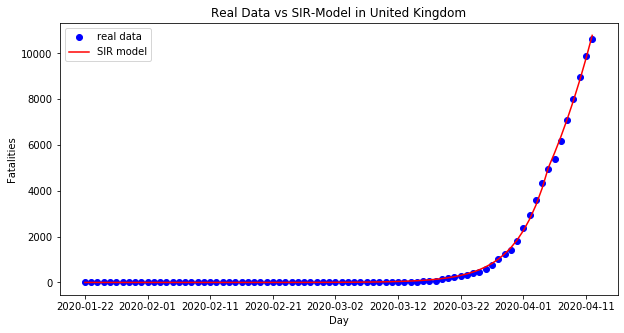

In [20]:
result, _ = fit_SIR("United Kingdom")
print(result.fit_report())
fitted_plot(result, "United Kingdom")

[[Model]]
    Model(SIR_model_with_lockdown_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 20
    # data points      = 82
    # variables        = 4
    chi-square         = 3.9312e+08
    reduced chi-square = 5040059.62
    Akaike info crit   = 1269.39928
    Bayesian info crit = 1279.02616
[[Variables]]
    N:                 1.438116e+09 (fixed)
    D:                 4.00000000 +/- 142963.485 (3574087.12%) (init = 10)
    R_0:               5.00000000 +/- 61435.9016 (1228718.03%) (init = 2)
    CaseFatalityRate:  0.10000000 +/- 2255.89016 (2255890.16%) (init = 0.01)
    max_days:          82 (fixed)
    L:                 1 (fixed)
    R_0_2:             1.58503107 +/- 20908.7563 (1319138.57%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, R_0_2)                =  1.000
    C(D, CaseFatalityRate)     =  1.000
    C(CaseFatalityRate, R_0_2) =  1.000
    C(R_0, R_0_2)              =  0.974
    C(D, R_0)          

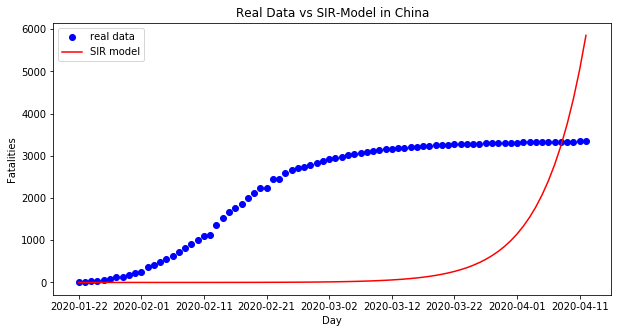

In [21]:
result, _ = fit_SIR("China")
print(result.fit_report())
fitted_plot(result, "China")

[[Model]]
    Model(SIR_model_with_lockdown_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 21
    # data points      = 82
    # variables        = 4
    chi-square         = 33624868.0
    reduced chi-square = 431088.051
    Akaike info crit   = 1067.77269
    Bayesian info crit = 1077.39957
[[Variables]]
    N:                 8.375396e+07 (fixed)
    D:                 4.00000000 +/- 165.039567 (4125.99%) (init = 10)
    R_0:               1.61848262 +/- 25.5310072 (1577.47%) (init = 2)
    CaseFatalityRate:  0.10000000 +/- 2.53424027 (2534.24%) (init = 0.01)
    max_days:          82 (fixed)
    L:                 63 (fixed)
    R_0_2:             0.10000000 +/- 0.90415562 (904.16%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, R_0)                  =  1.000
    C(D, CaseFatalityRate)     =  0.999
    C(R_0, CaseFatalityRate)   =  0.999
    C(R_0, R_0_2)              = -0.783
    C(D, R_0_2)                = -0

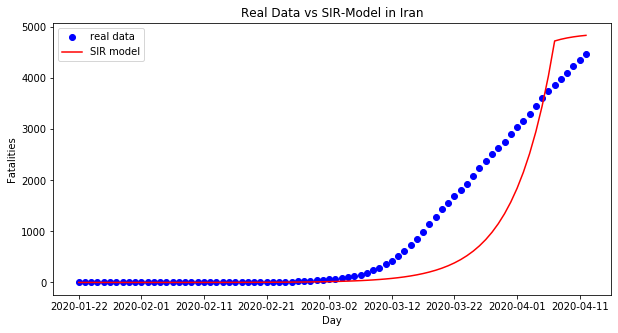

In [22]:
result, _ = fit_SIR("Iran")
print(result.fit_report())
fitted_plot(result, "Iran")

The prior models are able to capture some of the aspects of the virus quite well, it's not that hard to fit the curves to the outbreak period as they all look quite similar. However, the SIR model seems to fit well only the European countries as Italy, UK, Spain, France and Germany, since they share the same trajectory of the pandemic (second-wave), in contrast to China that belongs to the first-wave (mid-February).  

## **2.4 SIR with time-dependent R_0 and CFR** <a id="section24"></a>

To make better predictions, we now treat $R_{0}$ and CFR as functions, i.e. the variables change continuosly and don't jump at the Lockdown date. Also, the CFR was until now treated as constant, however, with more people infected, treatment becomes less available and the case fatality rate increases. Now, CFR is treated as a function of the ratio $\frac{I(t)}{N}$ (the fraction of infected of the total population):

$$ CFR(t) = s \cdot \frac{I(t)}{N} + \alpha_{OPT} $$

with $s$ being some arbitrary but fixed scaling factor and $\alpha_{OPT}$ being the CFR with optimal treatment available.

In [23]:
def extended_deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [24]:
def extended_SIR(N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0, **R_0_kwargs):
    '''
    R_0: callable
    '''
    I0, R0 = 1, 0  # Initial number of infected and recovered individuals (1 infected, 0 recovered) [this R0 has nothing to do with the basic reproduction number R0]
    S0 = N - I0 - R0 # Initial number of susceptible (everyone else)

    gamma = 1.0 / D  # see texts above

    def beta(t):
        return R_0(t, **R_0_kwargs) * gamma

    t = np.linspace(0, max_days, max_days)  # Grid of time points (in days)
    
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(extended_deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    def CFR(t):
        return CFR_OPT + CFR_scaling_factor * (I[t] / N)

    # Adding deaths
    X = np.zeros(max_days)
    for day in range(13, max_days):
        for valid_day in range(day-13):
            X[day] += CFR(valid_day) * beta(valid_day) * I[valid_day]

    return t, S, I, R, X, [R_0(t, **R_0_kwargs) for t in range(max_days)], N, [CFR(t) for t in range(max_days)]

In [25]:
def plot_extended_SIR(t, S, I, R, X, R_0, N, CFR):
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, X, 'r', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

    ax.set_xlabel('Time (days)')
    ax.title.set_text('SIR-Model with varying R_0 and CFR')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();
    
    
    # plt.figure(figsize=(10,4))
    
    f = plt.figure(figsize=(10,4))
    
    # sp1
    ax1 = f.add_subplot(121)
    ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    
    ax1.set_xlabel('Time (days)')
    ax1.title.set_text('R_0 over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax1.yaxis.set_tick_params(length=0)
    ax1.xaxis.set_tick_params(length=0)
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp2
    ax2 = f.add_subplot(122)
    ax2.plot(t, CFR, 'r--', alpha=0.7, linewidth=2, label='CFR')
    
    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('CFR over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

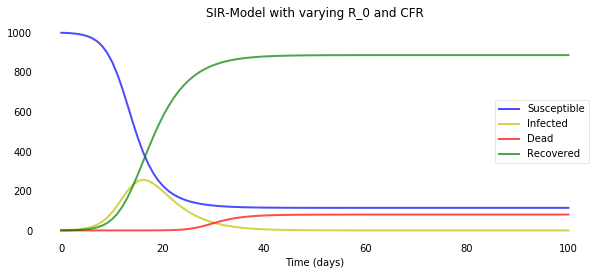

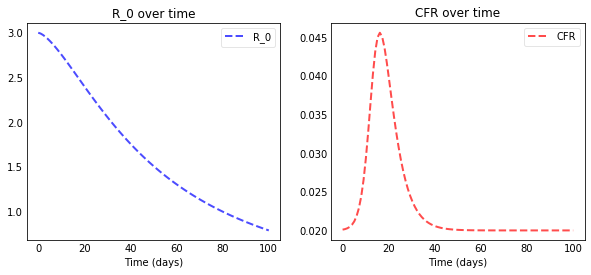

In [26]:
#example
N = 1_000
D = 4
max_days = 100

I0, R0 = 1, 0
S0 = N - I0 - R0
s = CFR_scaling_factor = 0.1
CFR_OPT = 0.02  # noone in hospital -> only 2% die

def new_R0(t, a, b, c):
    return a / (1 + (t/c)**b)


plot_extended_SIR(*extended_SIR(N, D, max_days, CFR_OPT, CFR_scaling_factor, new_R0, a=3.0, b=1.5, c=50))

## **2.4.1. Fitting extended SIR to data** <a id="section241"></a>

In [27]:
def fit_extended_SIR(country_name, R_0_function, region_name=None, fit_method="least_squares", **R_0_kwargs):

    y_data = train[(train["Country_Region"] == country_name)].Fatalities.values
    max_days = len(train.groupby("Date").sum().index) # constant for all countries
    # country specific values
    N = world_population.loc[world_population['Country (or dependency)'] == country_name]["Population (2020)"].values[0]

    # x_data is just [0, 1, ..., max_days] array
    x_data = np.linspace(0, max_days - 1, max_days, dtype=int)

    # curve fitting from here
    def extended_SIR_deaths(x, N, D, max_days, CFR_OPT, CFR_scaling_factor, **R_0_kwargs):
        t_, S_, I_, R_, X, R_0_, N_, CFR_ = extended_SIR(N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0=R_0_function, **R_0_kwargs)
        return X[x]

    mod = Model(extended_SIR_deaths)

    # initial values and bounds
    mod.set_param_hint('N', value=N, vary=False)
    mod.set_param_hint('max_days', value=max_days, vary=False)

    mod.set_param_hint('D', value=10, min=4, max=25)
    mod.set_param_hint('CFR_OPT', value=0.01, min=0.0001, max=0.1)
    mod.set_param_hint('CFR_scaling_factor', value=0.1, min=0.0001, max=1.0)
    if R_0_kwargs:
        for arg in R_0_kwargs:
            mod.set_param_hint(arg, value=R_0_kwargs[arg])

    params = mod.make_params()
    # print(params)
    result = mod.fit(y_data, params, method=fit_method, x=x_data)
    
    # fetch some result parameters
    CFR_OPT = result.params["CFR_OPT"].value
    CFR_scaling_factor = result.params["CFR_scaling_factor"].value
    R_0_result_params = {}
    for val in R_0_kwargs:
        R_0_result_params[val] = result.params[val].value

    
    # return result, country_name
    return result, country_name, N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, R_0_result_params

def fitted_plot_extended(result, country_name, region_name=None):
    y_data = train[(train["Country_Region"] == country_name)].Fatalities.values
    max_days = len(train.groupby("Date").sum().index) # constant for all countries
    x_data = np.linspace(0, max_days - 1, max_days, dtype=int)
    x_ticks = train[train["Country_Region"] == "Germany"].Date.values  # same for all countries
    
    plt.figure(figsize=(10,5))
    
    real_data, = plt.plot(x_data, y_data, 'bo', label="real data")
    SIR_fit = plt.plot(x_data, result.best_fit, 'r-', label="SIR model")
    
    plt.xlabel("Day")
    plt.xticks(x_data[::10], x_ticks[::10])
    plt.ylabel("Fatalities")
    plt.title("Real Data vs SIR-Model in " + country_name)
    plt.legend(numpoints=1, loc=2, frameon=None)
    plt.show()

[[Model]]
    Model(extended_SIR_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 299
    # data points      = 82
    # variables        = 6
    chi-square         = 217404.709
    reduced chi-square = 2860.58827
    Akaike info crit   = 658.389326
    Bayesian info crit = 672.829642
[[Variables]]
    N:                   6.048088e+07 (fixed)
    D:                   13.7396911 +/- 108.255524 (787.90%) (init = 10)
    max_days:            82 (fixed)
    CFR_OPT:             0.00788381 +/- 0.04412441 (559.68%) (init = 0.01)
    CFR_scaling_factor:  1.0018e-04 +/- 1.36824376 (1365818.27%) (init = 0.1)
    a:                   5.63389149 +/- 33.8714683 (601.21%) (init = 3)
    b:                   4.31432309 +/- 8.66845474 (200.92%) (init = 1.5)
    c:                   44.6576059 +/- 20.1725905 (45.17%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, a)                        =  1.000
    C(D, b)                       

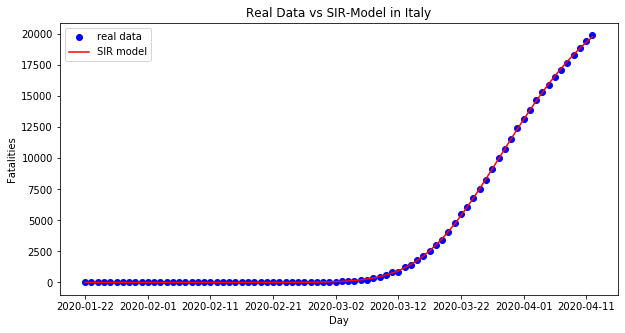

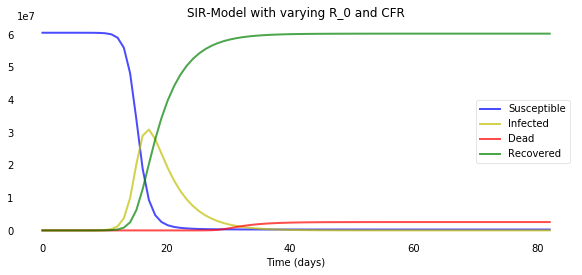

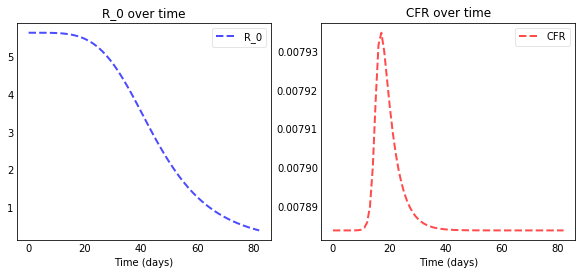

In [28]:
def new_R0(t, a, b, c):
    return a / (1 + (t/c)**b)

result, country_name, N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, R_0_result_params = fit_extended_SIR("Italy", new_R0, region_name=None, fit_method="least_squares", a=3.0, b=1.5, c=50)
print(result.fit_report())
fitted_plot(result, "Italy");
plot_extended_SIR(*extended_SIR(N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, **R_0_result_params))

[[Model]]
    Model(extended_SIR_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 251
    # data points      = 82
    # variables        = 6
    chi-square         = 533723.641
    reduced chi-square = 7022.67948
    Akaike info crit   = 732.034965
    Bayesian info crit = 746.475281
[[Variables]]
    N:                   4.675088e+07 (fixed)
    D:                   10.1590912 +/- 149.911236 (1475.64%) (init = 10)
    max_days:            82 (fixed)
    CFR_OPT:             6.7425e-04 +/- 0.00883160 (1309.84%) (init = 0.01)
    CFR_scaling_factor:  1.0036e-04 +/- 0.01401149 (13961.81%) (init = 0.1)
    a:                   4.32369099 +/- 46.0486152 (1065.03%) (init = 3)
    b:                   6.30066779 +/- 38.1907122 (606.14%) (init = 1.5)
    c:                   55.4684877 +/- 90.6939671 (163.51%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, c)                        = -1.000
    C(a, c)                     

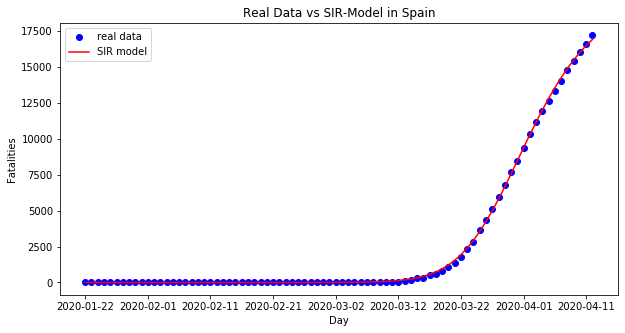

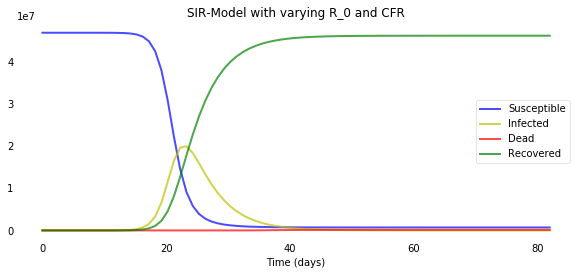

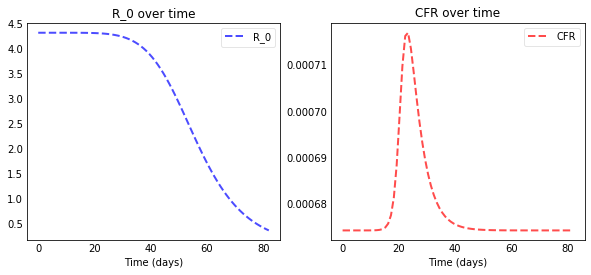

In [29]:
def new_R0(t, a, b, c):
    return a / (1 + (t/c)**b)

result, country_name, N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, R_0_result_params = fit_extended_SIR("Spain", new_R0, region_name=None, fit_method="least_squares", a=3.0, b=1.5, c=50)
print(result.fit_report())
fitted_plot(result, "Spain");
plot_extended_SIR(*extended_SIR(N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, **R_0_result_params))

[[Model]]
    Model(extended_SIR_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 137
    # data points      = 82
    # variables        = 6
    chi-square         = 1448139.28
    reduced chi-square = 19054.4643
    Akaike info crit   = 813.883805
    Bayesian info crit = 828.324120
[[Variables]]
    N:                   3.305788e+08 (fixed)
    D:                   5.52950017 +/- 85.3441750 (1543.43%) (init = 10)
    max_days:            82 (fixed)
    CFR_OPT:             1.0020e-04 +/- 0.00134037 (1337.64%) (init = 0.01)
    CFR_scaling_factor:  1.0014e-04 +/- 0.00124472 (1243.01%) (init = 0.1)
    a:                   4.21319255 +/- 55.1896669 (1309.93%) (init = 3)
    b:                   0.63735833 +/- 5.04604313 (791.71%) (init = 1.5)
    c:                   54.1391020 +/- 931.391681 (1720.37%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, CFR_OPT)                  = -0.999
    C(D, a)                     

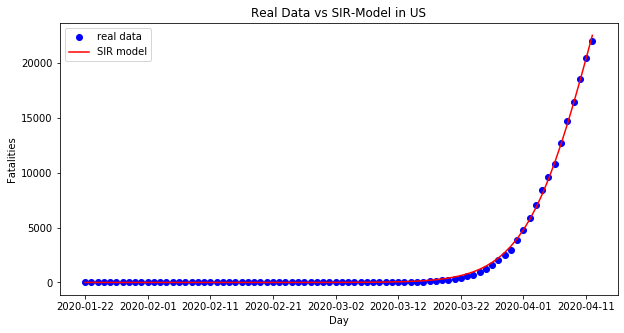

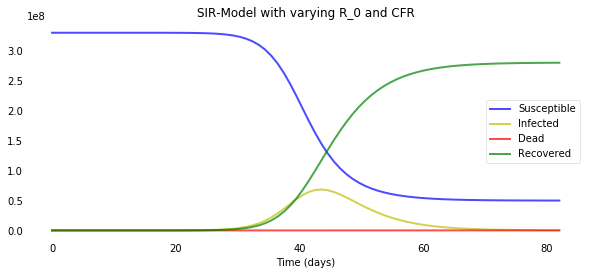

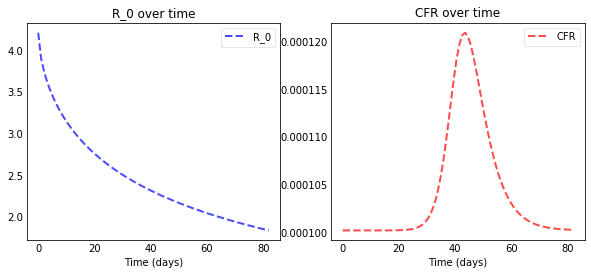

In [30]:
def new_R0(t, a, b, c):
    return a / (1 + (t/c)**b)

result, country_name, N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, R_0_result_params = fit_extended_SIR("US", new_R0, region_name=None, fit_method="least_squares", a=3.0, b=1.5, c=50)
print(result.fit_report())
fitted_plot(result, "US");
plot_extended_SIR(*extended_SIR(N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, **R_0_result_params))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


[[Model]]
    Model(extended_SIR_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 600
    # data points      = 82
    # variables        = 6
    chi-square         = 54920.0367
    reduced chi-square = 722.632062
    Akaike info crit   = 545.566971
    Bayesian info crit = 560.007287
[[Variables]]
    N:                   8.372584e+07 (fixed)
    D:                   4.36250561 +/- 38.0592852 (872.42%) (init = 10)
    max_days:            82 (fixed)
    CFR_OPT:             3.0517e-04 +/- 0.00196668 (644.44%) (init = 0.01)
    CFR_scaling_factor:  0.00283474 +/- 0.08874057 (3130.47%) (init = 0.1)
    a:                   2.13681637 +/- 10.0603236 (470.81%) (init = 3)
    b:                   8.32009539 +/- 19.3607021 (232.70%) (init = 1.5)
    c:                   65.4784406 +/- 66.5951711 (101.71%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, c)                  = -0.999
    C(D, a)                  =  0.998
    

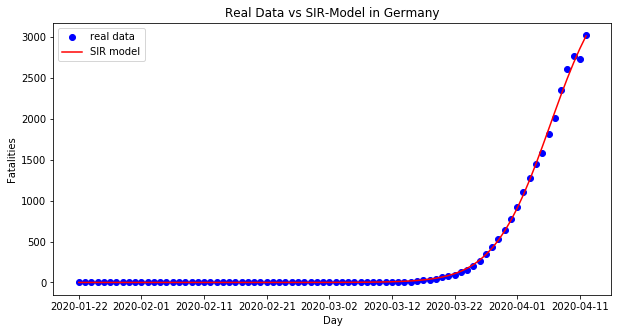

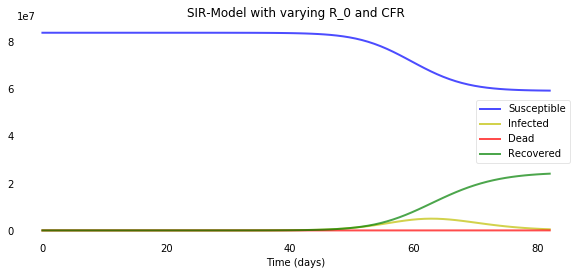

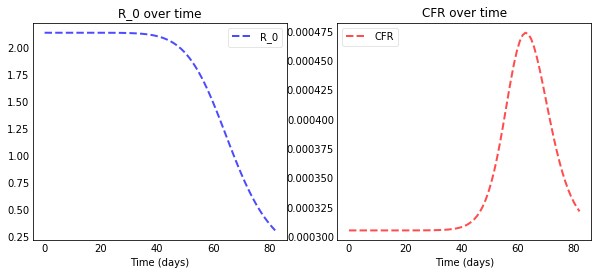

In [31]:
def new_R0(t, a, b, c):
    return a / (1 + (t/c)**b)

result, country_name, N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, R_0_result_params = fit_extended_SIR("Germany", new_R0, region_name=None, fit_method="least_squares", a=3.0, b=1.5, c=50)
print(result.fit_report())
fitted_plot(result, "Germany");
plot_extended_SIR(*extended_SIR(N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, **R_0_result_params))

[[Model]]
    Model(extended_SIR_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 168
    # data points      = 82
    # variables        = 6
    chi-square         = 271988.144
    reduced chi-square = 3578.79137
    Akaike info crit   = 676.757150
    Bayesian info crit = 691.197465
[[Variables]]
    N:                   6.780826e+07 (fixed)
    D:                   7.67082515 +/- 34.5900026 (450.93%) (init = 10)
    max_days:            82 (fixed)
    CFR_OPT:             1.0795e-04 +/- 5.0721e-04 (469.84%) (init = 0.01)
    CFR_scaling_factor:  1.0004e-04 +/- 0.00132041 (1319.85%) (init = 0.1)
    a:                   5.65763469 +/- 108.368889 (1915.45%) (init = 3)
    b:                   0.34396704 +/- 11.9578024 (3476.44%) (init = 1.5)
    c:                   50.3484828 +/- 6132.05382 (12179.22%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, CFR_OPT)                  = -0.996
    C(b, c)                     

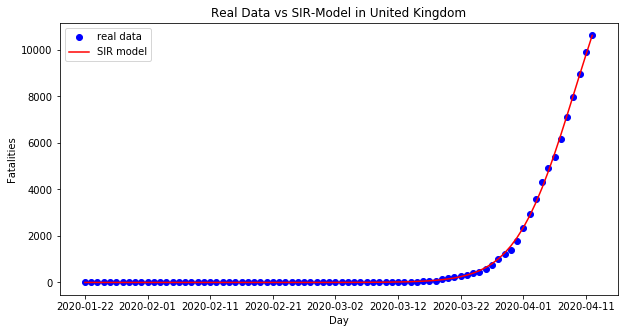

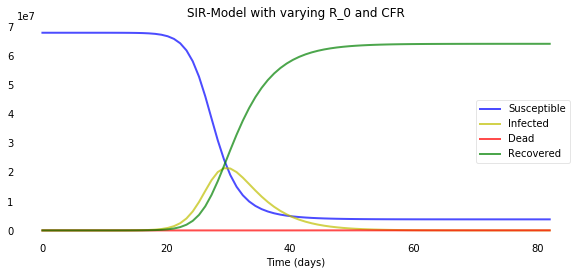

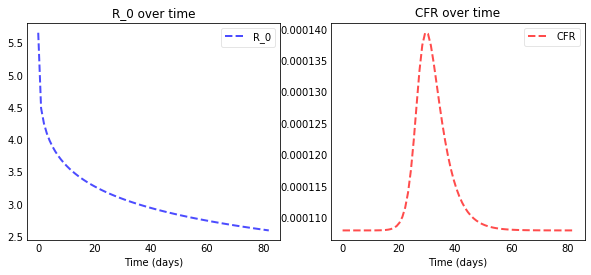

In [32]:
def new_R0(t, a, b, c):
    return a / (1 + (t/c)**b)

result, country_name, N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, R_0_result_params = fit_extended_SIR("United Kingdom", new_R0, region_name=None, fit_method="least_squares", a=3.0, b=1.5, c=50)
print(result.fit_report())
fitted_plot(result, "United Kingdom");
plot_extended_SIR(*extended_SIR(N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, **R_0_result_params))

[[Model]]
    Model(extended_SIR_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 600
    # data points      = 82
    # variables        = 6
    chi-square         = 1539668.54
    reduced chi-square = 20258.7966
    Akaike info crit   = 818.909395
    Bayesian info crit = 833.349710
[[Variables]]
    N:                   1.438116e+09 (fixed)
    D:                   15.0866431 +/- 25.5308308 (169.23%) (init = 10)
    max_days:            82 (fixed)
    CFR_OPT:             0.10000000 +/- 3.88427940 (3884.28%) (init = 0.01)
    CFR_scaling_factor:  0.94950174 +/- 20992.6733 (2210914.68%) (init = 0.1)
    a:                   1060.48144 +/- 21311.4370 (2009.60%) (init = 3)
    b:                   1.15316713 +/- 0.55903818 (48.48%) (init = 1.5)
    c:                   0.03612457 +/- 0.68707735 (1901.97%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(CFR_OPT, a)                  = -0.994
    C(a, c)                    

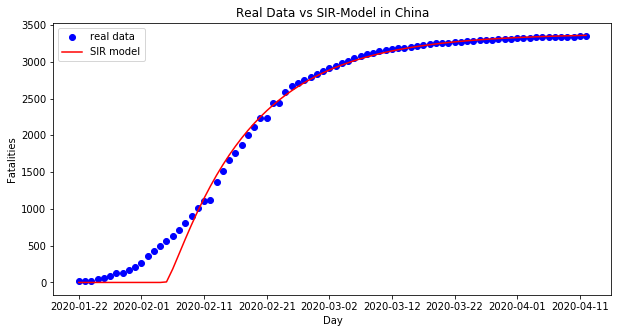

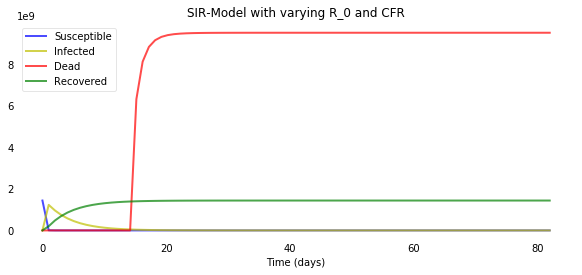

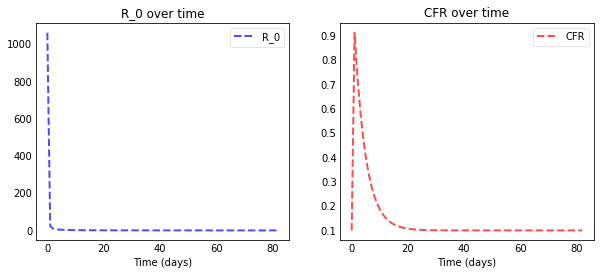

In [33]:
def new_R0(t, a, b, c):
    return a / (1 + (t/c)**b)

result, country_name, N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, R_0_result_params = fit_extended_SIR("China", new_R0, region_name=None, fit_method="least_squares", a=3.0, b=1.5, c=50)
print(result.fit_report())
fitted_plot(result, "China");
plot_extended_SIR(*extended_SIR(N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, **R_0_result_params))

[[Model]]
    Model(extended_SIR_deaths)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 390
    # data points      = 82
    # variables        = 6
    chi-square         = 69774.6423
    reduced chi-square = 918.087399
    Akaike info crit   = 565.197148
    Bayesian info crit = 579.637464
[[Variables]]
    N:                   8.375396e+07 (fixed)
    D:                   23.0969871 +/- 259.729370 (1124.52%) (init = 10)
    max_days:            82 (fixed)
    CFR_OPT:             9.9014e-04 +/- 0.02286917 (2309.69%) (init = 0.01)
    CFR_scaling_factor:  1.0004e-04 +/- 0.16405515 (163994.37%) (init = 0.1)
    a:                   11.5218141 +/- 86.1784438 (747.96%) (init = 3)
    b:                   3.07195352 +/- 12.0246247 (391.43%) (init = 1.5)
    c:                   32.0689373 +/- 41.7127262 (130.07%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(CFR_OPT, c)                  =  0.999
    C(D, b)                     

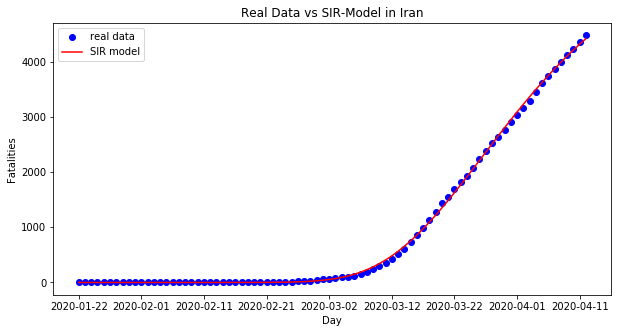

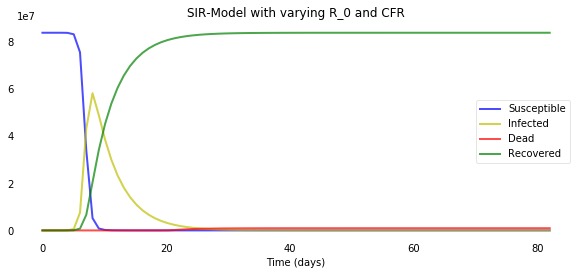

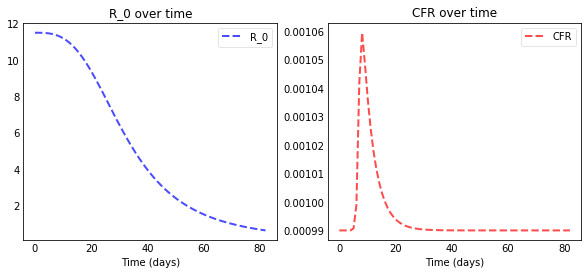

In [34]:
def new_R0(t, a, b, c):
    return a / (1 + (t/c)**b)

result, country_name, N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, R_0_result_params = fit_extended_SIR("Iran", new_R0, region_name=None, fit_method="least_squares", a=3.0, b=1.5, c=50)
print(result.fit_report())
fitted_plot(result, "Iran");
plot_extended_SIR(*extended_SIR(N, D, max_days, CFR_OPT, CFR_scaling_factor, R_0_function, **R_0_result_params))

In comparison with the non-extended SIR Model, the one with time-varying $R_{0}$ and CFR seems to fit better also to China and Iran. Moreover, we can take a look $R_{0}$ and CFR over time for each country. 